In [93]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, r2_score

In [94]:
df=pd.read_csv("Spam Email raw text for NLP.csv")
df.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [95]:
df.shape

(5796, 3)

In [96]:
df.info

<bound method DataFrame.info of       CATEGORY                                            MESSAGE  \
0            1  Dear Homeowner,\n\n \n\nInterest Rates are at ...   
1            1  ATTENTION: This is a MUST for ALL Computer Use...   
2            1  This is a multi-part message in MIME format.\n...   
3            1  IMPORTANT INFORMATION:\n\n\n\nThe new domain n...   
4            1  This is the bottom line.  If you can GIVE AWAY...   
...        ...                                                ...   
5791         0  I'm one of the 30,000 but it's not working ver...   
5792         0  Damien Morton quoted:\n\n>W3C approves HTML 4 ...   
5793         0  On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...   
5794         0  Once upon a time, Manfred wrote :\n\n\n\n> I w...   
5795         0  If you run Pick, and then use the "New FTOC" b...   

                                   FILE_NAME  
0     00249.5f45607c1bffe89f60ba1ec9f878039a  
1     00373.ebe8670ac56b04125c25100a36ab0510 

In [97]:
df.columns

Index(['CATEGORY', 'MESSAGE', 'FILE_NAME'], dtype='object')

In [98]:
df.drop(columns=["FILE_NAME"],inplace=True)
df.head(5)

,CATEGORY,MESSAGE
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
1,1,ATTENTION: This is a MUST for ALL Computer Use...
2,1,This is a multi-part message in MIME format.\n...
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
4,1,This is the bottom line. If you can GIVE AWAY...


## PREPROCESSING

In [99]:
lemmatizer=WordNetLemmatizer()

def preprocess_message(text):
    text=text.lower()      #convert to lowercase
    text=re.sub(r'[^\w\s]','',text)    #remove unwanted characters
    text=re.sub(r'\d+','',text)   #remove numbers
    
    words=word_tokenize(text) #split text in to words
    words=[word for word in words if word.isalpha() and len(word)>1]  #remove words of length less than 2

    stop_words=set(stopwords.words('english'))
    words=[word for word in words if word not in stop_words] #remove stopwords
    
    words=[lemmatizer.lemmatize(word) for word in words]  #lemmatizing
    
    return ' '.join(words)
df['clean_message']=df['MESSAGE'].apply(preprocess_message)

In [100]:
df.head()

,CATEGORY,MESSAGE,clean_message
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",dear homeowner interest rate lowest point year...
1,1,ATTENTION: This is a MUST for ALL Computer Use...,attention must computer user newspecial packag...
2,1,This is a multi-part message in MIME format.\n...,multipart message mime format contenttype text...
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,important information new domain name finally ...
4,1,This is the bottom line. If you can GIVE AWAY...,bottom line give away cd free people like one ...


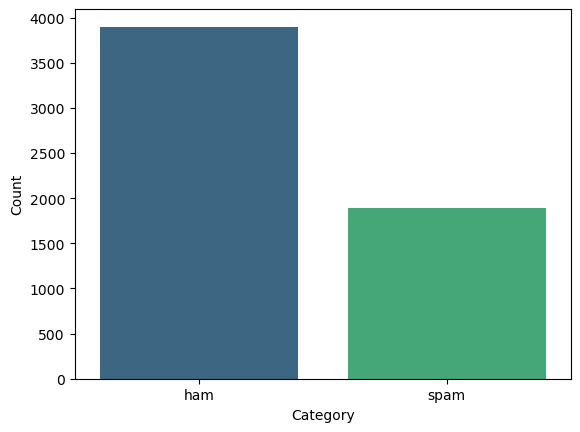

In [72]:
df['CATEGORY']=df['CATEGORY'].map({0:'ham',1:'spam'})

cate_counts = df['CATEGORY'].value_counts().reset_index()
cate_counts.columns = ['Category', 'Count']

sns.barplot(x='Category',y='Count',data=cate_counts,palette='viridis')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [73]:
print(cate_counts)

  Category  Count
0      ham   3900
1     spam   1896


In [101]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

smote = SMOTE(random_state=42)
x_resampled,y_resampled=smote.fit_resample(x_train,y_train)

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x=vectorizer.fit_transform(df['clean_message'])
y=df['CATEGORY']

In [103]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True), 
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}
results = {}

for name, model in models.items():
    print(f"Training and evaluating {name}...")
    model.fit(x_resampled,y_resampled)
    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    try:
        y_proba = model.predict_proba(x_test)[:, 1]  
        r2 = r2_score(y_test, y_proba)
    except:
        r2 = None

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'R^2 Score': r2
    }

for name, metrics in results.items():
    print(f"\n{name} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Training and evaluating Naive Bayes...
Training and evaluating Gradient Boosting...
Training and evaluating Random Forest...
Training and evaluating SVC...
Training and evaluating Decision Tree...
Training and evaluating K-Nearest Neighbors...

Naive Bayes Metrics:
Accuracy: 0.9833
Precision: 0.9848
F1 Score: 0.9758
R^2 Score: 0.9303

Gradient Boosting Metrics:
Accuracy: 0.9643
Precision: 0.9578
F1 Score: 0.9482
R^2 Score: 0.8595

Random Forest Metrics:
Accuracy: 0.9753
Precision: 0.9730
F1 Score: 0.9641
R^2 Score: 0.8662

SVC Metrics:
Accuracy: 0.9753
Precision: 0.9947
F1 Score: 0.9633
R^2 Score: 0.9566

Decision Tree Metrics:
Accuracy: 0.9551
Precision: 0.9383
F1 Score: 0.9352
R^2 Score: 0.8021

K-Nearest Neighbors Metrics:
Accuracy: 0.5975
Precision: 0.4632
F1 Score: 0.6331
R^2 Score: -0.3455
